# load data

In [5]:
import pandas as pd
import json
from ast import literal_eval
import plotly.express as px
import matplotlib.pyplot as plt
from datetime import datetime
import glob


In [6]:
# Find all chunk files (assuming they follow a consistent naming pattern)
file_paths = glob.glob('../datasets/2025_csv/_chunk_*.csv')
# Read each file (limiting rows if necessary) and concatenate
dfs = [pd.read_csv(fp, nrows=10000) for fp in file_paths]
df_all = pd.concat(dfs, ignore_index=True)

# # Printing the original columns
# print("Dataset columns:")
# print(df.columns)
# # print(df.head)

In [7]:
# df_all = pd.read_csv('../datasets/2025_csv/_chunk_0_100000.csv')

print(df_all.columns)

Index(['$insert_id', 'amplitude_id', 'app', 'city', 'client_event_time',
       'client_upload_time', 'country', 'data', 'data_type', 'device_family',
       'device_id', 'device_type', 'dma', 'event_id', 'event_properties',
       'event_time', 'event_type', 'language', 'library', 'os_name',
       'os_version', 'platform', 'processed_time', 'region',
       'server_received_time', 'server_upload_time', 'session_id', 'user_id',
       'user_properties', 'uuid'],
      dtype='object')


# process data - unnest

In [8]:
# Parse nested JSON columns
json_cols = ['data', 'event_properties', 'user_properties']
for col in json_cols:
    df_all[col] = df_all[col].apply(lambda x: literal_eval(str(x)) if pd.notna(x) else {})

# Flatten nested columns
df_all['event_slug'] = df_all['event_properties'].apply(lambda x: x.get('slug', 'unknown'))
df_all['event_displayName'] = df_all['event_properties'].apply(lambda x: x.get('displayName', 'unknown'))
df_all['user_roles'] = df_all['user_properties'].apply(lambda x: x.get('roles', []))

# Convert timestamps to a parsable time value
time_cols = ['client_event_time', 'event_time', 'server_received_time']
for col in time_cols:
    df_all[col] = pd.to_datetime(df_all[col], errors='coerce')

In [9]:
# session_id will be the uuid 
cols = ['session_id', 'event_time', 'client_event_time', 'user_id', 'user_roles', 'city', 'event_displayName', 'event_slug', 'event_type']
df_granular = df_all[cols]
df_granular.head()

session_id              event_time       client_event_time  \
0  1737021244277 2025-01-16 13:28:02.427 2025-01-16 13:28:02.427   
1  1737021244277 2025-01-16 13:28:02.433 2025-01-16 13:28:02.433   
2  1737021244277 2025-01-16 13:28:04.229 2025-01-16 13:28:04.229   
3  1737021244277 2025-01-16 13:28:04.263 2025-01-16 13:28:04.263   
4  1737021244277 2025-01-16 13:28:04.268 2025-01-16 13:28:04.268   

                                user_id     user_roles    city  \
0  0c4896b7-08fa-4cb4-852f-27ad584f0864  [underwriter]  Mumbai   
1  0c4896b7-08fa-4cb4-852f-27ad584f0864  [underwriter]  Mumbai   
2  0c4896b7-08fa-4cb4-852f-27ad584f0864  [underwriter]  Mumbai   
3  0c4896b7-08fa-4cb4-852f-27ad584f0864  [underwriter]  Mumbai   
4  0c4896b7-08fa-4cb4-852f-27ad584f0864  [underwriter]  Mumbai   

        event_displayName                      event_slug  \
0                 unknown                         general   
1                 unknown                         unknown   
2  Account Details Header          account-details-header   
3     Latest Policy Table             latest-policy-table   
4                 unknown  documents-and-compliance-table   

                                 event_type  
0              account-lines::layout:render  
1                      account-lines:::view  
2              account-lines::widget:render  
3              account-lines::widget:render  
4  account-lines::configurable-table:render

# process data - aggregate by session id

In [10]:
# The original ordering is not sorted by session_id
df_granular = df_granular.sort_values(['session_id', 'event_time'])

# Group together consequetive events in the same session
df_granular['session_change'] = df_granular['session_id'].ne(df_granular['session_id'].shift()).cumsum()
df = df_granular.groupby('session_change').agg(
    session_id=('session_id', 'first'),

    start_time=('event_time', 'first'),
    num_events=('event_time', 'count'),
    elapsed_time=('event_time', lambda x: (x.max() - x.min()).total_seconds() / 60 if len(x) > 1 else 0),

    user_id=('user_id', 'first'),
    user_roles=('user_roles', 'first'),
    city=('city', 'first'),
    
    event_displayNames=('event_displayName', list),
    event_slugs=('event_slug', list),
    event_types=('event_type', list)
).reset_index(drop=True)

print(df['session_id'].is_unique)

# df.head(50)
# df['event_types'].head(50)
pd.set_option('display.max_colwidth', 500)
print(df['event_types'].head(50))


True
0                                                                                                                                                                                                                                                                 [session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end, session_end]
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [session_e

# Sankey diagram

In [11]:
print(len(df_granular['event_type'].unique()))
print(df_granular['event_type'].unique())

168
['session_end' 'application-window-opened' 'session_start'
 'agency-dashboard::layout:render' 'agency-dashboard:::view'
 'agency-dashboard::widget:render'
 'agency-dashboard::configurable-table:render'
 '::nav-header:user-signed-out'
 'dashboard:my-book:configurable-table:render'
 'dashboard:my-book:widget:render'
 'triaged-submission-list:my-book:configurable-table:render'
 'triaged-submission-list:my-book::view' 'dashboard:my-book:layout:render'
 'dashboard:my-book::view' '::nav-header:action-center-click'
 'action-center:::view' 'account:::view' 'account-lines:::view'
 'account-lines::layout:render' 'account-lines::widget:render'
 'account-lines::configurable-table:render'
 ':all-accounts:configurable-table:render' ':all-accounts:widget:render'
 ':all-accounts:layout:render' ':all-accounts::view'
 'submissions:policy-definition::submit-click'
 'submissions:all-policy:configurable-table:render'
 'submissions:all-policy::view'
 'submissions:triaged_submissions-definition::view'
 '

In [12]:
import plotly.graph_objects as go

df_granular_test = pd.DataFrame({'event_type': df_granular['event_type'].apply(lambda event: event.split(':')[0]).unique()})

df_test = df.copy()
# df_test['event_types'] = df['event_types'].apply(lambda events: [event.split(':')[0] for event in events])
df_test['event_types'] = df['event_types'].apply(lambda events: ['START'] + [ (event.split(':')[0] + ':' + event.split(':')[1] if len(event.split(':')) > 1 else event.split(':')[0]) for event in events] + ['END'])

nodes = list(df_granular['event_type'].apply(lambda event: (event.split(':')[0] + ':' + event.split(':')[1] if len(event.split(':')) > 1 else event.split(':')[0]) ).unique())
nodes += ['START', 'END']

node_indices = {node: i for i, node in enumerate(nodes)}

print(f"there are {len(nodes)} distinct event_types: {nodes}")
df_test['event_types'].head(50)

transitions = []
# for seq in df_test['event_types'].head(10000):
for seq in df_test['event_types']:
    # print(seq)
    for i in range(len(seq) - 1):
        # if (seq[i] != seq[i+1]) and seq[i] != "session_end" and seq[i+1] != "session_end" and seq[i] != "session_start" and seq[i+1] != "session_start":
        if (seq[i] != seq[i+1]):
            transitions.append((seq[i], seq[i+1]))

df_sankey = pd.DataFrame(transitions, columns=['source', 'target'])
transition_counts = df_sankey.value_counts().reset_index()
transition_counts.columns = ['source', 'target', 'count']
transition_counts = transition_counts[transition_counts['count'] >= 10]


df_sankey.head()
print(df_sankey.shape)


x_positions = [0] * len(nodes)  # Default all to 0

# Set the 'session_start' node to be at the far left (x=0)
# session_start_index = nodes.index('session_start')
# x_positions[session_start_index] = 0

fig = go.Figure(go.Sankey(
    node=dict(label=nodes, x=x_positions),
    link=dict(
        source=[node_indices[src] for src in transition_counts['source']],
        target=[node_indices[tgt] for tgt in transition_counts['target']],
        value=transition_counts['count']
    )
))

fig.update_layout(title_text="User Journey Flow", font=dict(size=10, family="Arial", color="black"), height=1000, width = 1800)

# Save the figure as JSON
fig_json = fig.to_json()
with open("User_Journey_Flow.json", "w") as f:
    f.write(fig_json)

fig.show()


there are 66 distinct event_types: ['session_end', 'application-window-opened', 'session_start', 'agency-dashboard:', ':', 'dashboard:my-book', 'triaged-submission-list:my-book', 'action-center:', 'account:', 'account-lines:', ':all-accounts', 'submissions:policy-definition', 'submissions:all-policy', 'submissions:triaged_submissions-definition', 'triaged-submission:triaged_submissions-definition', 'triaged-submission-list:triaged_submissions-definition', 'submissions:policy-create', 'account-property-rating:perils', 'action-center:action-details', 'dashboard:portfolio-insights', 'account-auto-rating:', 'submissions:exposures-create', 'submissions:all-exposures', 'EMPTY', 'submissions:all-account', 'submissions:account-create', 'account-broker-view:', 'agency-account:', 'submissions:all-ingest_policy_through_pd', 'submissions:ingest_policy_through_pd-create', 'account-property-rating:', 'all-accounts:renewals', 'submissions:all-financial_lines', 'dashboard:team-insights', 'account-prop

In [23]:
import plotly.graph_objects as go


nodes = list(df_granular['event_type'].unique())
node_indices = {node: i for i, node in enumerate(nodes)}

# print(f"there are {len(nodes)} distinct event_types: {nodes}")

transitions = []
for seq in df['event_types'].head(1000):
    # print(seq)
    for i in range(len(seq) - 1):
        if (seq[i] != seq[i+1]):
            transitions.append((seq[i], seq[i+1]))

df_sankey = pd.DataFrame(transitions, columns=['source', 'target'])
transition_counts = df_sankey.value_counts().reset_index()
transition_counts.columns = ['source', 'target', 'count']

df_sankey.head()
print(df_sankey.shape)
print(transition_counts)


(15230, 2)
                                       source  \
0                account-lines::widget:render   
1    account-lines::configurable-table:render   
2                account-lines::layout:render   
3                        account-lines:::view   
4                              account:::view   
..                                        ...   
546                   dashboard:my-book::view   
547                   dashboard:my-book::view   
548                   dashboard:my-book::view   
549                   dashboard:my-book::view   
550                 application-window-opened   

                                                              target  count  
0                           account-lines::configurable-table:render   1704  
1                                       account-lines::widget:render   1493  
2                                               account-lines:::view    989  
3                                                     account:::view    487  
4         

In [24]:
fig = go.Figure(go.Sankey(
    node=dict(label=nodes),
    link=dict(
        source=[node_indices[src] for src in transition_counts['source']],
        target=[node_indices[tgt] for tgt in transition_counts['target']],
        value=transition_counts['count']
    )
))

fig.update_layout(title_text="User Journey Flow", font_size=4, height=800)
fig.show()

# simple visualizations

In [25]:
print(df_all.shape) # raw data
print(df.shape) # processed data

average_num_events = df['num_events'].mean()
average_elapsed_time = df['elapsed_time'].mean()

print(f"The average number of events is: {average_num_events}")
print(f"The elapsed time (minutes) is: {average_elapsed_time}")

(100000, 33)
(4843, 10)
The average number of events is: 20.648358455502787
The elapsed time (minutes) is: 6.964784682359419


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3


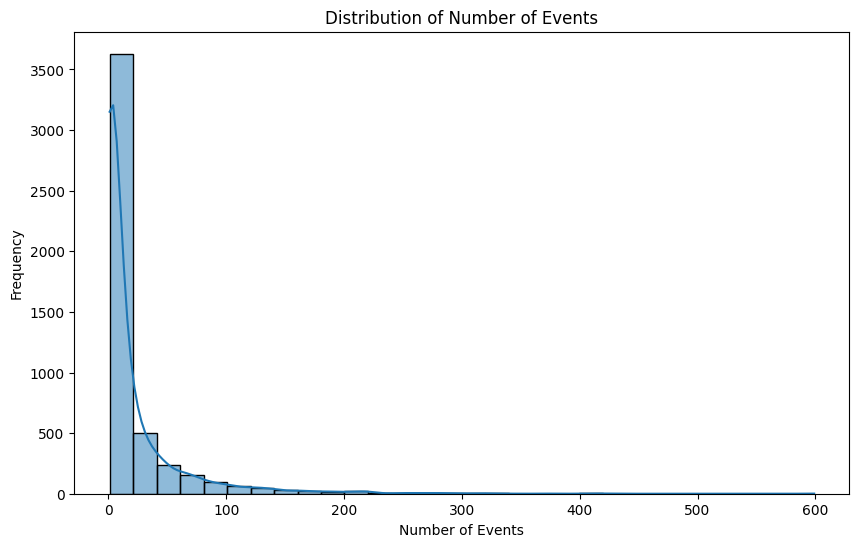

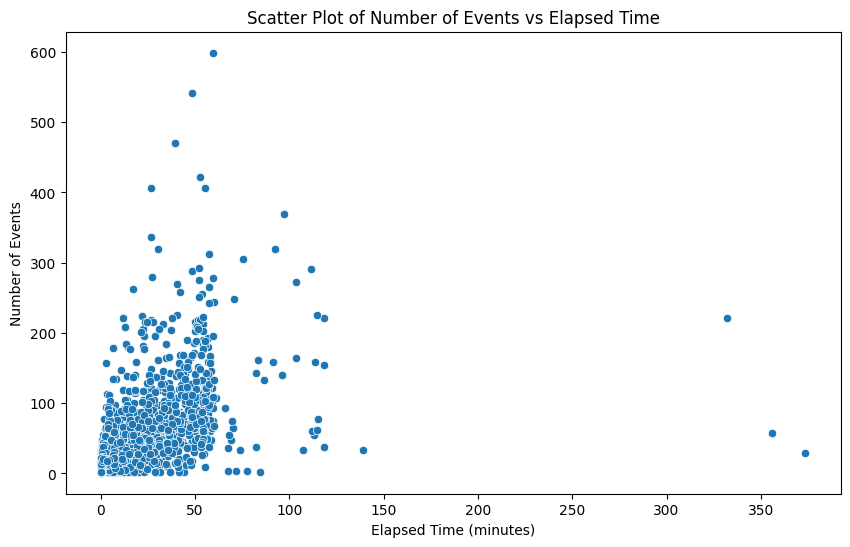

In [33]:
# histogram: num_events
plt.figure(figsize=(10, 6))
sns.histplot(df['num_events'], kde=True, bins=30)
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Events')
plt.savefig('Distribution_of_Number_of_Events.png', bbox_inches='tight')
plt.show()

# scatterplot: num_events vs elapsed_time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='elapsed_time', y='num_events', data=df)
plt.xlabel('Elapsed Time (minutes)')
plt.ylabel('Number of Events')
plt.title('Scatter Plot of Number of Events vs Elapsed Time')
plt.savefig('Scatter_Plot_of_Number_of_Events_vs_Elapsed_Time.png', bbox_inches='tight')
plt.show()
